In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
funcs = os.listdir('functions')

for func in funcs:
    if func.startswith('__') or func == 'import_all_functions.py':
        continue
    func = func.replace('.py','')
    print(f'{func} imported')
    exec(f'from functions.{func} import *')

import_to_df imported
impute_cond_mean imported
get_kaggle_data imported
test imported
process_cabin imported
process_name imported
process_data imported


In [3]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as pyplot
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas_profiling as pp
pd.set_option('display.max_columns', None)

In [8]:
files = get_kaggle_data(competition="titanic")

files downloaded for titanic competition
   test.csv
   train.csv
   gender_submission.csv
located in /competition_data/


In [14]:
input_data = import_to_df(files)

In [15]:
train_df = input_data['train']


In [7]:
pp.ProfileReport(train_df)

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


In [16]:
test_df = input_data['test']

In [9]:
pp.ProfileReport(test_df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


In [17]:
train_df = process_data(train_df)
test_df = process_data(test_df)


In [18]:
# make sure both sets have the same cols
valid_cols = list(set(train_df.columns) & set(test_df.columns))

In [19]:
X_train = train_df[valid_cols].fillna(method='ffill')
y_train = train_df['Survived']

X_test = test_df[valid_cols].fillna(method='ffill')

scaler = StandardScaler()
X_train = np.nan_to_num(scaler.fit_transform(X_train))
X_test = np.nan_to_num(scaler.transform(X_test))

In [20]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
# model = LogisticRegression(max_iter=1000)
lr = LogisticRegression(solver='liblinear', max_iter=1000, C=0.01)
# model.fit(X_train, y_train)
# scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
# print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8489903564138059
Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}


In [32]:
y_pred = grid_search.predict_proba(X_test)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

0         1
0  0.780307  0.219693
1  0.788581  0.211419
2  0.767604  0.232396
3  0.833359  0.166641
4  0.789302  0.210698

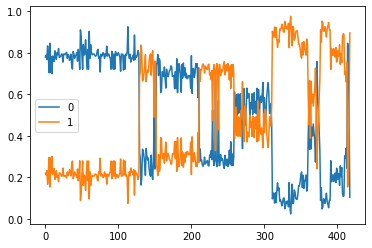

In [52]:
plotdf = pd.DataFrame(y_pred)
plotdf.plot()
def f(x):
    if x < 0.25:
        return 1
    else:
        return 0
plotdf.head()

In [54]:
submission_df = pd.DataFrame()
submission_df['PassengerId'] = input_data['test']['PassengerId']
submission_df['Survived'] = plotdf.loc[:,0].apply(f)


In [56]:
submission_df.head()

PassengerId  Survived
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1

In [57]:
submission_df.to_csv('submission7.csv', index=False)

In [58]:
!kaggle competitions submit -f 'submission7.csv' -m 'forced 0.75 prob survive' titanic

100%|████████████████████████████████████████| 2.77k/2.77k [00:03<00:00, 777B/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [59]:
!kaggle competitions submissions -c titanic

fileName         date                 description                   status    publicScore  privateScore  
---------------  -------------------  ----------------------------  --------  -----------  ------------  
submission7.csv  2021-04-23 07:28:32  forced 0.75 prob survive      complete  0.56220      None          
submission7.csv  2021-04-23 07:18:45  forced 0.75 prob survive      complete  0.62200      None          
submission7.csv  2021-04-23 07:18:05  forced 0.75 prob survive      error     None         None          
submission0.csv  2021-04-23 07:12:31  all died lol                  complete  0.62200      None          
submission6.csv  2021-04-22 07:08:52  scaled regged log reg         complete  0.47607      None          
submission5.csv  2021-04-20 07:06:45  rf with manual downweighting  complete  0.52870      None          
submission2.csv  2021-04-16 11:12:04  simple log reg                complete  0.54545      None          
submission3.csv  2021-04-16 08:36:41  scaled l